# CS 598 DLH Final Project Draft

Name: Fabio Vera

Team: 133

Project: 11

Github link: https://github.com/fverac/cs589dlh

In [1]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, \
                            recall_score, f1_score, confusion_matrix, classification_report, \
                            PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay
# may have to install xgboost via `pip install xgboost`
from xgboost import XGBClassifier
import xgboost as xgb


pd.set_option('display.max_columns', None)

# Introduction
<!-- This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->


Sepsis accounts for over 5.3 million deaths a year and has an approximate mortality of 30%. With such a high mortality rate, it is desirable to construct an accurate and reliable prognostic (or survival classification) model to inform the allocation of scarce clinical resources. Past attempts at such a prognostic model have either employed traditional predictive methods such as logistic regression, or the use of clinical scoring systems such as Simplified Acute Physiology Score-II. These approaches however, can be limiting in their assumptions or scope of features used for prediction. Machine learning methods such as XGboost may be able to achieve higher performance, with the ability to handle many features and identify nonlinear relationships in the data.

The paper I am reproducing proposes using XGBoost for this classification task, and demonstrates improvement in performance over typical models such as logistic regression, achieving an AUC of 0.857 using XGboost vs 0.819 using logistic regression.

I will attempt to reproduce their classification experiments, and compare the performance of XGboost on the dataset against traditional methods such as logistic regression.

# Scope of Reproducibility:

<!-- List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: xxxxxxx
2.   Hypothesis 2: xxxxxxx

You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc) -->


Hypotheses:
1. I will see if XGboost can achieve higher performance than logistic regression in sepsis mortality prediction.

# Methodology

##  Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->

Data is all from MIMIC III v1.4, which "is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge)."

Data can be obtained from this link after completing the required training.
https://physionet.org/content/mimiciii/1.4/

Precomputed features like first-day vital signs and many more were obtained from Google BigQuery, which in addition to storing 
More information as well as underlying code for creating these precomputed/derived tables can be found here: 
https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts

Additionally, here are some resources for accessing MIMIC through BigQuery:
https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/

#### Sepsis filters

Obtain diagnosis codes for sepsis, to be used for filtering downstream

In [3]:
# icd9 codes I care about
sepsis_codes = (
    pd.read_csv(f'mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv')
    .loc[lambda df: df['SHORT_TITLE'].str.lower().isin(['sepsis', 'severe sepsis', 'septic shock'])] #sepsis”, “severe sepsis” and “septic shock”
    ['ICD9_CODE']
    .values
)
sepsis_codes

array(['99591', '99592', '78552'], dtype=object)

In [ ]:
diagnoses = pd.read_csv('mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv')
diagnoses

In [ ]:
sepsis_diagnoses = (
    diagnoses
    .loc[
        lambda df: df['ICD9_CODE'].isin(sepsis_codes)
    ]
)
sepsis_diagnoses

#### Loading and cleaning master table

In [51]:
# helper function to print shape and message via .pipe, while returning df to continue data processing
def print_shape(df, msg = ''):
    print(msg, df.shape)
    return df

In [65]:
Xy = (
    pd.read_csv('mimic_concepts/icustay_detail.csv') # table of all icu stays along with demographic information
    .pipe(print_shape, 'Initial shape: ')
    .loc[lambda df: df['hadm_id'].isin(sepsis_diagnoses['HADM_ID'])] # sepsis filter
    .pipe(print_shape, 'After filtering to sepsis: ')

    .loc[lambda df: df['first_hosp_stay']] # only keep first hospital stays
    .loc[lambda df: df['first_icu_stay']] # only keep first icu stay info
    .pipe(print_shape, 'After filtering to first hospital+icu stay: ')

    .loc[lambda df: df['admission_age'].ge(18)] # age filter
    .loc[lambda df: df['admission_age'].le(89)] # age filter
    .pipe(print_shape, 'After filtering ages: ')

    # create y marker
    .assign(
        death_within_30 = lambda df:
        df['hospital_expire_flag']
        # if length of stay > 30, mark as not dead within 30 days
        .mask(
            df['los_hospital'].gt(30),
            0
        )
    )
    
    # inner merge all features. Don't lose too many rows
    .merge(
        pd.read_csv('mimic_concepts/labs_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/heightweight.csv'),
        how='inner',
        on = ['icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/vitals_first_day.csv'),
        how='inner', # this drops like 20 rows
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    ) # deal with conflicting glucose vals
    .merge(
        pd.read_csv('mimic_concepts/gcs_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    # .merge( # LEAVE OUT NOW FOR SIMPLICITY
    #     pd.read_csv('mimic_concepts/blood_gas_first_day_arterial.csv'),
    #     how='left',
    #     on = ['subject_id', 'hadm_id', 'icustay_id'],
    # )
    .merge(
        pd.read_csv('mimic_concepts/elixhauser_ahrq_v37.csv')
        # only keep cols with at least 1% of data. maybe just drop this..
        .loc[
            :,
            lambda df:
            df.sum().div(df.shape[0]).gt(0.01)
        ],
        how='inner',
        on = ['subject_id', 'hadm_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/ventilation_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/rrt_first_day.csv'),
        how='inner',
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/urine_output_first_day.csv'),
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/sapsii.csv')[['subject_id', 'hadm_id', 'icustay_id', 'sapsii']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/sofa.csv')[['subject_id', 'hadm_id', 'icustay_id', 'SOFA']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .merge(
        pd.read_csv('mimic_concepts/qsofa.csv')[['subject_id', 'hadm_id', 'icustay_id', 'qSOFA']],
        how='inner', #this drops a few hundred
        on = ['subject_id', 'hadm_id', 'icustay_id'],
    )
    .pipe(print_shape, 'After inner-merging on features: ')


    
    # drop columns not intended for modeling
    .drop(
        columns=[
            'icustay_id',
            'dod',
            'admittime',
            'dischtime',
            'los_hospital',
            'ethnicity',
            'hospital_expire_flag',
            'hospstay_seq',
            'first_hosp_stay',
            'intime',
            'outtime',
            'los_icu',
            'icustay_seq',
            'first_icu_stay',
            'subject_id',
            'hadm_id'
        ]
    )
    
    # drop rows where >20% features are missing
    .loc[
        lambda df:
        df
        .isna()
        .sum(axis=1)
        .div(df.shape[1]).lt(0.2)
    ]
    .pipe(print_shape, 'After dropping rows where >20% features are missing: ')



    # xgboost can natively handle categorical, and onehot, but maybe in interest of time just do it in pandas
    .assign(gender = lambda df: df['gender'].replace({'F':0, 'M': 1}))
    .pipe(
        lambda df:
        pd.concat([
            df.drop(columns='ethnicity_grouped'),
            df['ethnicity_grouped'].pipe(pd.get_dummies, prefix='ethnicity')
        ], axis=1)
    )
    .fillna(-1)
    
    .reset_index(drop=True)
    .pipe(print_shape, 'Final shape: ')

)
# Xy

Initial shape:  (61051, 19)
After filtering to sepsis:  (6126, 19)
After filtering to first hospital+icu stay:  (3534, 19)
After filtering ages:  (3262, 19)
After inner-merging on features:  (3169, 102)
After dropping rows where >20% features are missing:  (3155, 86)
Final shape:  (3155, 92)


#### Data exploration

In [61]:
# target value counts
Xy['death_within_30'].value_counts()

0    2295
1     860
Name: death_within_30, dtype: int64

In [62]:
# observe most commonly missing features
Xy.eq(-1).sum().sort_values(ascending=False).head(20)

bands_min        1842
bands_max        1842
height_first     1565
height_max       1563
height_min       1563
albumin_min      1121
albumin_max      1121
bilirubin_max     674
bilirubin_min     674
lactate_max       341
lactate_min       341
ptt_min           191
ptt_max           191
pt_max            181
pt_min            181
inr_max           181
inr_min           181
gcsmotor           44
weight_max         36
weight_min         36
dtype: int64

##   Model
<!-- The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it. -->
  

Use xgboost and compare against logistic regression. Currently no hyperparameter tuning

In [16]:
y_col = 'death_within_30'
X = Xy.drop(columns=[y_col])
y = Xy[y_col]

In [42]:
pred_df = pd.DataFrame()

kf = KFold(n_splits=5)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print('fold:', i)
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    # model = LogisticRegressionCV(max_iter=10000)
    # model = XGBClassifier(n_estimators=1000, objective='binary:logistic', eval_metric='auc')
    # model = RandomForestClassifier()
    model = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=4,
                min_child_weight=6,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=27)
    
    # if True:
    #     xgb_param = model.get_xgb_params()
    #     xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    #     cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=3,
    #         metrics='auc', early_stopping_rounds=50,)
    #     model.set_params(n_estimators=cvresult.shape[0])
    
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    pred_probas = model.predict_proba(X_test)[:, 1]
    
    pred_df_fold = pd.DataFrame({
        'y_actual': y_test,
        'y_pred': preds,
        'y_pred_proba': pred_probas,
        'fold': i,
        'test_inds': test_index
    })
    pred_df = pd.concat([pred_df, pred_df_fold])
    
    

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


# Results
<!-- In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc) -->


#### ROC metrics

auc

In [64]:
roc_auc_score(pred_df['y_actual'], pred_df['y_pred_proba'])

0.8065795206971678

roc curve


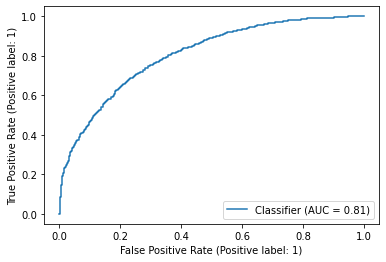

In [41]:
RocCurveDisplay.from_predictions(pred_df['y_actual'], pred_df['y_pred_proba'])

# Discussion

<!-- In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase. -->



Out of the box, my XGBoost performance did not seem to achieve the accuracy that the original paper did. I have been currently been achieving .806 AUC with XGBoost while the paper achieved ~0.85 AUC. There are still some optimizations that I can make, however, such as hyperparameter tuning, and allowing XGboost to natively handle missing and categorical values, instead of imputing and one-hot encoding them myself, respectively. 

In terms of what was difficult, I underestimated how much work it was going to be to process the data to be ready for modeling. There is a lot of feature engineering required on the raw data to get it into a state that is ready for modeling. In particular, the raw CHARTEVENTS table is quite large (~30 gb uncompressed) and understandably has most of the rich features, but its size makes it quite difficult to deal with on a compute station like a laptop. Thankfully, I was able to find and leverage several precomputed derived tables on BigQuery to make the feature engineering process smoother. 

As a suggestion for the authors, the single most important thing the authors could do to improve reproducibility would be to release their code. This could clear things up across the whole process, from the way they train the model to the way they ingest and process the data.

In the next phase I will continue to make efforts to approach the performance that the original authors achieved with XGboost, as well as construct comparisons between logistic regression.

# References

1. Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost. J Transl Med 18, 462 (2020). https://doi.org/10.1186/s12967-020-02620-5
2. Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.
3. Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.
4. Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
